<a href="https://colab.research.google.com/github/JENkt4k/OpenGisStuff/blob/main/Working_Simplify_QuadArc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install matplotlib geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
import matplotlib.pyplot as plt
import numpy as np

class QuadEdge:
    def __init__(self, org, dest):
        self.org = org
        self.dest = dest
        self.rot = None
        self.sym = None
        self.onext = None


def create_edge(org, dest):
    e1 = QuadEdge(org, dest)
    e2 = QuadEdge(dest, org)
    e1.sym = e2
    e2.sym = e1
    e1.onext = e1
    return e1
def flip_edge(edge):
    a = edge.onext
    b = edge.sym.onext
    edge.org, edge.dest = edge.dest, edge.org

    edge.onext = a
    edge.sym.onext = b

    # Update rotations
    if a is not None:
        a.rot = edge
    if b is not None:
        b.rot = edge.sym

    return edge

def split_edge(edge, new_vertex):
    e1 = QuadEdge(edge.org, new_vertex)
    e2 = QuadEdge(new_vertex, edge.dest)
    e3 = QuadEdge(new_vertex, edge.org)
    e4 = QuadEdge(edge.dest, new_vertex)
    e1.sym = e2
    e2.sym = e1
    e3.sym = e4
    e4.sym = e3
    e1.onext = edge.onext
    e2.onext = edge.sym.onext
    e3.onext = edge
    e4.onext = edge.sym
    edge.onext = e3
    edge.sym.onext = e4
    return e1

def swap_edge(edge):
    a = edge.onext
    b = edge.sym.onext
    c = a.onext if a is not None else None
    d = b.onext if b is not None else None
    edge.org, edge.dest = edge.dest, edge.org

    edge.onext = c
    edge.sym.onext = d

    # Update rotations
    if c is not None:
        c.rot = edge
    if d is not None:
        d.rot = edge.sym

    return edge

def display_quad_edge(vertices, quad_edges, delaunay=None, voronoi=None):
    # Create a new figure and axis
    fig, ax = plt.subplots()

    # Plot the polygon
    ax.plot(vertices[:, 0], vertices[:, 1], 'b-')

    # Plot the quad edges
    for edge in quad_edges:
        start = edge.org
        end = edge.dest
        ax.plot([start[0], end[0]], [start[1], end[1]], 'r-')

    # Plot Delaunay triangulation
    if delaunay and len(vertices) >= 3:
        for simplex in delaunay.simplices:
            if len(vertices) > np.max(simplex):
                ax.plot(vertices[simplex, 0], vertices[simplex, 1], 'g-', alpha=0.5)

    # Plot Voronoi regions
    if voronoi and len(vertices) > 0:
        for region in voronoi.regions:
            if region and -1 not in region and len(voronoi.vertices) > np.max(region):
                ax.plot(voronoi.vertices[region, 0], voronoi.vertices[region, 1], 'm-', alpha=0.5)

    # Set plot attributes
    ax.set_aspect('equal')
    ax.set_xlim(vertices[:, 0].min() - 1, vertices[:, 0].max() + 1)
    ax.set_ylim(vertices[:, 1].min() - 1, vertices[:, 1].max() + 1)

    # Display the plot
    plt.show()

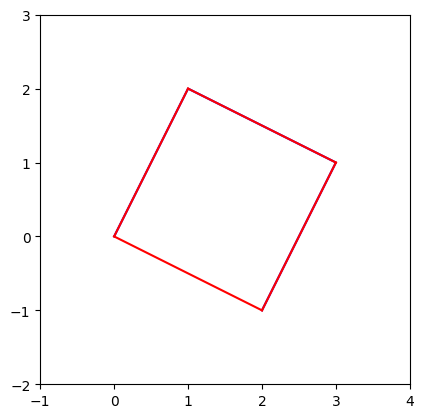

In [39]:
# Example usage
vertices = [(0, 0), (1, 2), (3, 1), (2, -1)]
quad_edges = [create_edge(vertices[i], vertices[(i+1) % len(vertices)]) for i in range(len(vertices))]

display_quad_edge(vertices, quad_edges)

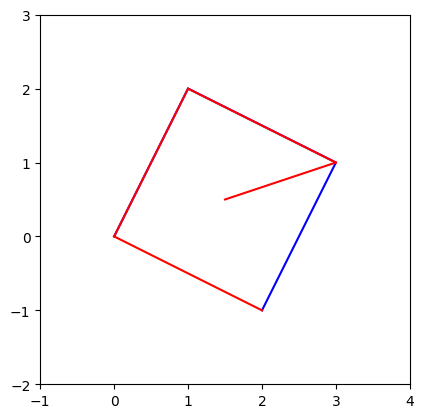

In [40]:
# Perform operations on the quad edges
quad_edges[1] = flip_edge(quad_edges[1])
new_vertex = (1.5, 0.5)
quad_edges[2] = split_edge(quad_edges[2], new_vertex)
quad_edges[3] = swap_edge(quad_edges[3])

display_quad_edge(vertices, quad_edges)

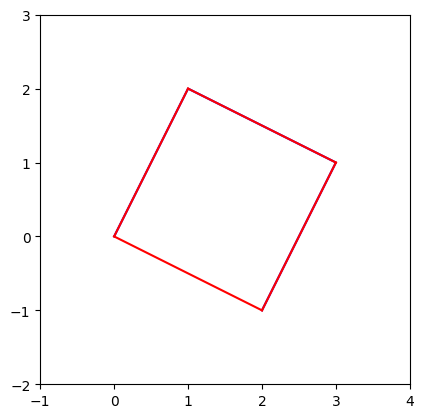

In [41]:
# Perform operations on the quad edges
quad_edges = [create_edge(vertices[i], vertices[(i+1) % len(vertices)]) for i in range(len(vertices))]
quad_edges[1] = flip_edge(quad_edges[1])
display_quad_edge(vertices, quad_edges)

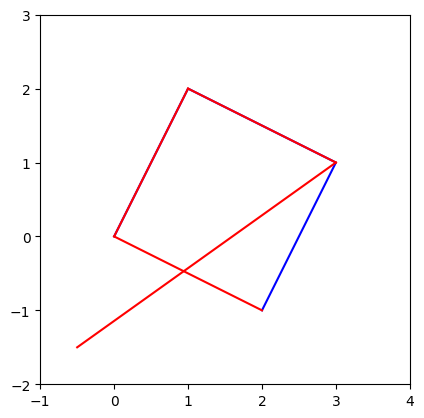

In [43]:
# Perform operations on the quad edges
new_vertex = (-0.5, -1.5)
quad_edges[2] = split_edge(quad_edges[2], new_vertex)
quad_edges[3] = swap_edge(quad_edges[3])
display_quad_edge(vertices, quad_edges)

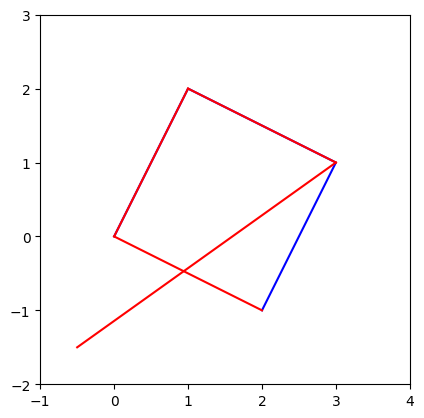

In [44]:
quad_edges = [create_edge(vertices[i], vertices[(i+1) % len(vertices)]) for i in range(len(vertices))]
quad_edges[-2] = split_edge(quad_edges[-2], new_vertex)
quad_edges[-1] = swap_edge(quad_edges[-1])
display_quad_edge(vertices, quad_edges)

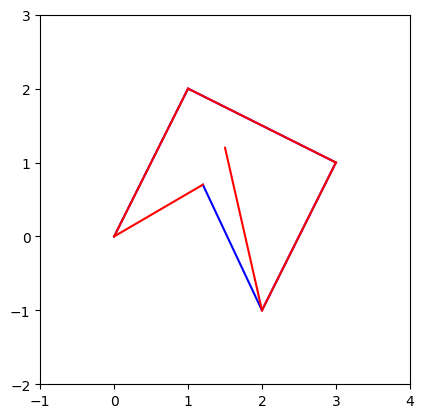

In [45]:
vertices.append((1.2,0.7))
new_vertex = (1.5, 1.2)
quad_edges = [create_edge(vertices[i], vertices[(i+1) % len(vertices)]) for i in range(len(vertices))]
quad_edges[-2] = split_edge(quad_edges[-2], new_vertex)
quad_edges[-1] = swap_edge(quad_edges[-1])
display_quad_edge(vertices, quad_edges)

In [46]:
print(vertices)

[(0, 0), (1, 2), (3, 1), (2, -1), (1.2, 0.7)]


In [47]:
from scipy.spatial import Delaunay, Voronoi

def simplify_points(points, epsilon):
    delaunay = Delaunay(points)
    voronoi = Voronoi(points)

    # Create an empty list to store the simplified points
    simplified_points = []

    # Iterate over the vertices in the triangulation
    for vertex in range(len(points)):
        # Get the indices of the Voronoi vertices neighboring the current vertex
        neighbor_vertices = voronoi.ridge_vertices[voronoi.point_region[vertex]]

        # Remove any -1 indices (corresponding to infinite Voronoi vertices)
        neighbor_vertices = [v for v in neighbor_vertices if v != -1]

        # Calculate the centroid of the neighboring vertices
        centroid = np.mean(voronoi.vertices[neighbor_vertices], axis=0)

        # Calculate the Euclidean distance between the current vertex and the centroid
        distance = np.linalg.norm(np.array(points[vertex]) - centroid)

        # Check if the distance between the current vertex and the centroid is greater than epsilon
        if distance > epsilon:
            simplified_points.append(points[vertex])

    return simplified_points, delaunay, voronoi

In [56]:
print(len(vertices))
print(vertices[:10])

[(-90.33321693376683, 37.84773055375268), (-90.33299180355885, 37.84744081208646), (-90.33266356397604, 37.8472109964618), (-90.33216591606015, 37.84701291521213), (-90.33163144626928, 37.84690295062899), (-90.33113573689508, 37.84665154750434), (-90.33067593793743, 37.84632206729651), (-90.33047928377107, 37.845880568338885), (-90.33035089731294, 37.84539732458961), (-90.33018979835487, 37.844888475632104)]


[(-90.33321693376683, 37.84773055375268), (-90.33299180355885, 37.84744081208646), (-90.33266356397604, 37.8472109964618), (-90.33216591606015, 37.84701291521213), (-90.33163144626928, 37.84690295062899), (-90.33113573689508, 37.84665154750434), (-90.33067593793743, 37.84632206729651), (-90.33047928377107, 37.845880568338885), (-90.33035089731294, 37.84539732458961), (-90.33018979835487, 37.844888475632104)]
in if
[(-90.33321693376683, 37.84773055375268), (-90.33299180355885, 37.84744081208646), (-90.33266356397604, 37.8472109964618), (-90.33216591606015, 37.84701291521213), (-90.33163144626928, 37.84690295062899), (-90.33113573689508, 37.84665154750434), (-90.33067593793743, 37.84632206729651), (-90.33047928377107, 37.845880568338885), (-90.33035089731294, 37.84539732458961), (-90.33018979835487, 37.844888475632104)]
[(-90.33321693376683, 37.84773055375268), (-90.33299180355885, 37.84744081208646), (-90.33266356397604, 37.8472109964618), (-90.33216591606015, 37.84701291521213), (-90.3

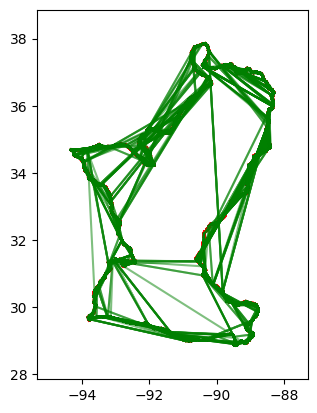

In [61]:
print(vertices[:10])

#quad_edges = [create_edge(vertices[i], vertices[(i+1) % len(vertices)]) for i in range(len(vertices))]

# Specify the epsilon value for simplification
epsilon = 5.5

# Convert vertices to NumPy array
points = vertices

# Check if there are enough points for triangulation
if len(points) >= 3:
    print("in if")
    # Simplify the points
    simplified_points, delaunay, voronoi = simplify_points(points, epsilon)
    print(vertices[:10])

    print(simplified_points[:10])
    simplified_points = np.array(simplified_points)
    print(simplified_points[:10])
    quad_edges = [create_edge(vertices[i], vertices[(i+1) % len(vertices)]) for i in range(len(vertices))]

    # Display the quad edges with the simplified points, Delaunay, and Voronoi information
    display_quad_edge(simplified_points, quad_edges, delaunay, voronoi)
    # # Display the quad edges with the simplified points
    # display_quad_edge(simplified_points, quad_edges, delaunay, voronoi)
else:
    print("Not enough points for triangulation.")

In [62]:
def display_quad_edge(vertices, quad_edges, delaunay=None, voronoi=None):
    # Create a new figure and axis
    fig, ax = plt.subplots()

    # Plot the polygon
    ax.plot(vertices[:, 0], vertices[:, 1], 'b-')

    # Plot the quad edges
    for edge in quad_edges:
        start = edge.org
        end = edge.dest
        ax.plot([start[0], end[0]], [start[1], end[1]], 'r-')

    # Plot Voronoi regions
    if voronoi and len(vertices) > 0:
        for region in voronoi.regions:
            if region and -1 not in region and len(voronoi.vertices) > np.max(region):
                ax.plot(voronoi.vertices[region, 0], voronoi.vertices[region, 1], 'm-', alpha=0.5)

    # Plot Delaunay triangulation
    if delaunay and len(vertices) >= 3:
        for simplex in delaunay.simplices:
            if len(vertices) > np.max(simplex):
                ax.plot(vertices[simplex, 0], vertices[simplex, 1], 'g-', alpha=0.5)

    # Set plot attributes
    ax.set_aspect('equal')
    ax.set_xlim(vertices[:, 0].min() - 1, vertices[:, 0].max() + 1)
    ax.set_ylim(vertices[:, 1].min() - 1, vertices[:, 1].max() + 1)

    # Display the plot
    plt.show()

[(-90.33321693376683, 37.84773055375268), (-90.33299180355885, 37.84744081208646), (-90.33266356397604, 37.8472109964618), (-90.33216591606015, 37.84701291521213), (-90.33163144626928, 37.84690295062899), (-90.33113573689508, 37.84665154750434), (-90.33067593793743, 37.84632206729651), (-90.33047928377107, 37.845880568338885), (-90.33035089731294, 37.84539732458961), (-90.33018979835487, 37.844888475632104)]
in if
[(-90.33321693376683, 37.84773055375268), (-90.33299180355885, 37.84744081208646), (-90.33266356397604, 37.8472109964618), (-90.33216591606015, 37.84701291521213), (-90.33163144626928, 37.84690295062899), (-90.33113573689508, 37.84665154750434), (-90.33067593793743, 37.84632206729651), (-90.33047928377107, 37.845880568338885), (-90.33035089731294, 37.84539732458961), (-90.33018979835487, 37.844888475632104)]
[(-90.33321693376683, 37.84773055375268), (-90.33299180355885, 37.84744081208646), (-90.33266356397604, 37.8472109964618), (-90.33216591606015, 37.84701291521213), (-90.3

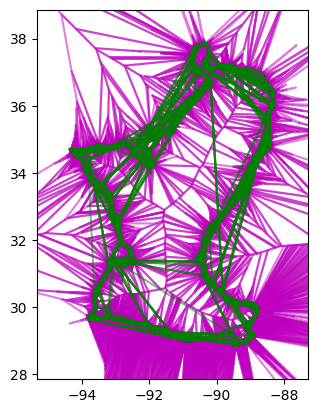

In [63]:
print(vertices[:10])

#quad_edges = [create_edge(vertices[i], vertices[(i+1) % len(vertices)]) for i in range(len(vertices))]

# Specify the epsilon value for simplification
epsilon = 5.5

# Convert vertices to NumPy array
points = vertices

# Check if there are enough points for triangulation
if len(points) >= 3:
    print("in if")
    # Simplify the points
    simplified_points, delaunay, voronoi = simplify_points(points, epsilon)
    print(vertices[:10])

    print(simplified_points[:10])
    simplified_points = np.array(simplified_points)
    print(simplified_points[:10])
    quad_edges = [create_edge(vertices[i], vertices[(i+1) % len(vertices)]) for i in range(len(vertices))]

    # Display the quad edges with the simplified points, Delaunay, and Voronoi information
    display_quad_edge(simplified_points, quad_edges, delaunay, voronoi)
    # # Display the quad edges with the simplified points
    # display_quad_edge(simplified_points, quad_edges, delaunay, voronoi)
else:
    print("Not enough points for triangulation.")

In [64]:
def display_quad_edge(vertices, quad_edges, delaunay=None, voronoi=None):
    # Create a new figure and axis
    fig, ax = plt.subplots()

    # Plot Voronoi regions
    if voronoi and len(vertices) > 0:
        for region in voronoi.regions:
            if region and -1 not in region and len(voronoi.vertices) > np.max(region):
                ax.plot(voronoi.vertices[region, 0], voronoi.vertices[region, 1], 'm-', alpha=0.5)

    # Plot Delaunay triangulation
    if delaunay and len(vertices) >= 3:
        for simplex in delaunay.simplices:
            if len(vertices) > np.max(simplex):
                ax.plot(vertices[simplex, 0], vertices[simplex, 1], 'g-', alpha=0.5)

    # Plot the quad edges
    for edge in quad_edges:
        start = edge.org
        end = edge.dest
        ax.plot([start[0], end[0]], [start[1], end[1]], 'r-')
    
    # Plot the polygon
    ax.plot(vertices[:, 0], vertices[:, 1], 'b-')

    # Set plot attributes
    ax.set_aspect('equal')
    ax.set_xlim(vertices[:, 0].min() - 1, vertices[:, 0].max() + 1)
    ax.set_ylim(vertices[:, 1].min() - 1, vertices[:, 1].max() + 1)

    # Display the plot
    plt.show()

[(-90.33321693376683, 37.84773055375268), (-90.33299180355885, 37.84744081208646), (-90.33266356397604, 37.8472109964618), (-90.33216591606015, 37.84701291521213), (-90.33163144626928, 37.84690295062899), (-90.33113573689508, 37.84665154750434), (-90.33067593793743, 37.84632206729651), (-90.33047928377107, 37.845880568338885), (-90.33035089731294, 37.84539732458961), (-90.33018979835487, 37.844888475632104)]
in if
[(-90.33321693376683, 37.84773055375268), (-90.33299180355885, 37.84744081208646), (-90.33266356397604, 37.8472109964618), (-90.33216591606015, 37.84701291521213), (-90.33163144626928, 37.84690295062899), (-90.33113573689508, 37.84665154750434), (-90.33067593793743, 37.84632206729651), (-90.33047928377107, 37.845880568338885), (-90.33035089731294, 37.84539732458961), (-90.33018979835487, 37.844888475632104)]
[(-90.33321693376683, 37.84773055375268), (-90.33299180355885, 37.84744081208646), (-90.33266356397604, 37.8472109964618), (-90.33216591606015, 37.84701291521213), (-90.3

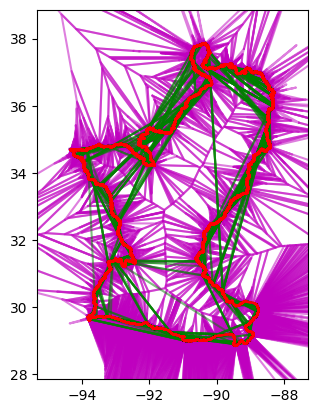

In [65]:
print(vertices[:10])

#quad_edges = [create_edge(vertices[i], vertices[(i+1) % len(vertices)]) for i in range(len(vertices))]

# Specify the epsilon value for simplification
epsilon = 5.5

# Convert vertices to NumPy array
points = vertices

# Check if there are enough points for triangulation
if len(points) >= 3:
    print("in if")
    # Simplify the points
    simplified_points, delaunay, voronoi = simplify_points(points, epsilon)
    print(vertices[:10])

    print(simplified_points[:10])
    simplified_points = np.array(simplified_points)
    print(simplified_points[:10])
    quad_edges = [create_edge(vertices[i], vertices[(i+1) % len(vertices)]) for i in range(len(vertices))]

    # Display the quad edges with the simplified points, Delaunay, and Voronoi information
    display_quad_edge(simplified_points, quad_edges, delaunay, voronoi)
    # # Display the quad edges with the simplified points
    # display_quad_edge(simplified_points, quad_edges, delaunay, voronoi)
else:
    print("Not enough points for triangulation.")

In [66]:
def display_quad_edge(vertices, quad_edges, delaunay=None, voronoi=None):
    # Create a new figure and axis
    fig, ax = plt.subplots()

    # Plot Voronoi regions
    if voronoi and len(vertices) > 0:
        for region in voronoi.regions:
            if region and -1 not in region and len(voronoi.vertices) > np.max(region):
                ax.plot(voronoi.vertices[region, 0], voronoi.vertices[region, 1], 'm-', alpha=0.5)

    # Plot Delaunay triangulation
    if delaunay and len(vertices) >= 3:
        for simplex in delaunay.simplices:
            if len(vertices) > np.max(simplex):
                ax.plot(vertices[simplex, 0], vertices[simplex, 1], 'g-', alpha=0.5)

    # Plot the quad edges
    for edge in quad_edges:
        start = edge.org
        end = edge.dest
        ax.plot([start[0], end[0]], [start[1], end[1]], 'r-')
    
    # Plot the polygon
    ax.plot(vertices[:, 0], vertices[:, 1], 'b-')

    # Set plot attributes
    ax.set_aspect('equal')
    ax.set_xlim(vertices[:, 0].min() - 1, vertices[:, 0].max() + 1)
    ax.set_ylim(vertices[:, 1].min() - 1, vertices[:, 1].max() + 1)

    # Display the plot
    plt.show()

[(-90.33321693376683, 37.84773055375268), (-90.33299180355885, 37.84744081208646), (-90.33266356397604, 37.8472109964618), (-90.33216591606015, 37.84701291521213), (-90.33163144626928, 37.84690295062899), (-90.33113573689508, 37.84665154750434), (-90.33067593793743, 37.84632206729651), (-90.33047928377107, 37.845880568338885), (-90.33035089731294, 37.84539732458961), (-90.33018979835487, 37.844888475632104)]
in if
[(-90.33321693376683, 37.84773055375268), (-90.33299180355885, 37.84744081208646), (-90.33266356397604, 37.8472109964618), (-90.33216591606015, 37.84701291521213), (-90.33163144626928, 37.84690295062899), (-90.33113573689508, 37.84665154750434), (-90.33067593793743, 37.84632206729651), (-90.33047928377107, 37.845880568338885), (-90.33035089731294, 37.84539732458961), (-90.33018979835487, 37.844888475632104)]
[(-90.33321693376683, 37.84773055375268), (-90.33299180355885, 37.84744081208646), (-90.33266356397604, 37.8472109964618), (-90.33216591606015, 37.84701291521213), (-90.3

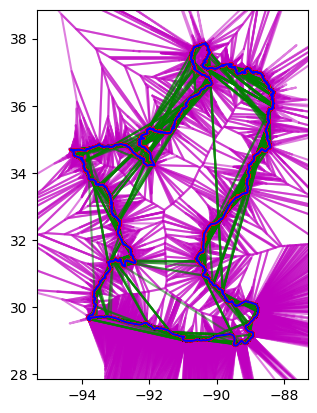

In [67]:
print(vertices[:10])

#quad_edges = [create_edge(vertices[i], vertices[(i+1) % len(vertices)]) for i in range(len(vertices))]

# Specify the epsilon value for simplification
epsilon = 5.5

# Convert vertices to NumPy array
points = vertices

# Check if there are enough points for triangulation
if len(points) >= 3:
    print("in if")
    # Simplify the points
    simplified_points, delaunay, voronoi = simplify_points(points, epsilon)
    print(vertices[:10])

    print(simplified_points[:10])
    simplified_points = np.array(simplified_points)
    print(simplified_points[:10])
    quad_edges = [create_edge(vertices[i], vertices[(i+1) % len(vertices)]) for i in range(len(vertices))]

    # Display the quad edges with the simplified points, Delaunay, and Voronoi information
    display_quad_edge(simplified_points, quad_edges, delaunay, voronoi)
    # # Display the quad edges with the simplified points
    # display_quad_edge(simplified_points, quad_edges, delaunay, voronoi)
else:
    print("Not enough points for triangulation.")

In [59]:
print(len(simplified_points))
print(len(vertices))
print(len(simplified_points)/len(vertices))

24619
105865
0.23255089028479667


105865


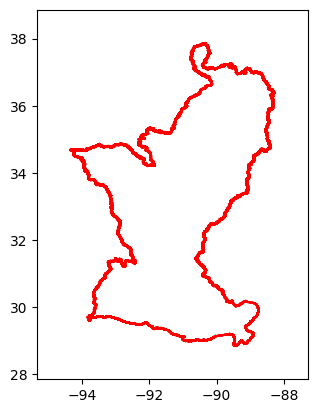

In [49]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Path to the NHD Shapefile
nhd_shapefile = '/content/drive/MyDrive/Gis_stuff/WBD_08_HU2_Shape/Shape/WBDHU2.shp' #'/content/drive/MyDrive/Gis_stuff/WBDHU2.shp' #'/content/WBDHU2.shp'

# Read NHD Shapefile into a GeoDataFrame
nhd_data = gpd.read_file(nhd_shapefile)

def extract_polygon_vertices(polygon):
    return list(polygon.exterior.coords)

# Create a list to store the vertices
vertices = []

# Iterate over each polygon in the GeoDataFrame
for polygon in nhd_data['geometry']:
    # Extract the vertices of the polygon
    polygon_vertices = extract_polygon_vertices(polygon)
    
    # Add the polygon vertices to the list
    vertices.extend(polygon_vertices)

# Display the vertices
print(len(vertices))

quad_edges = [create_edge(vertices[i], vertices[(i+1) % len(vertices)]) for i in range(len(vertices))]

display_quad_edge(vertices, quad_edges)

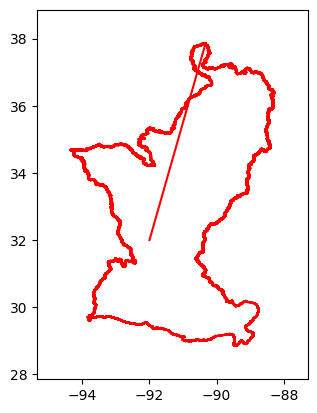

In [ ]:
# Perform operations on the quad edges
quad_edges[1] = flip_edge(quad_edges[1])
new_vertex = (-92, 32)
quad_edges[2] = split_edge(quad_edges[2], new_vertex)
quad_edges[3] = swap_edge(quad_edges[3])

display_quad_edge(vertices, quad_edges)

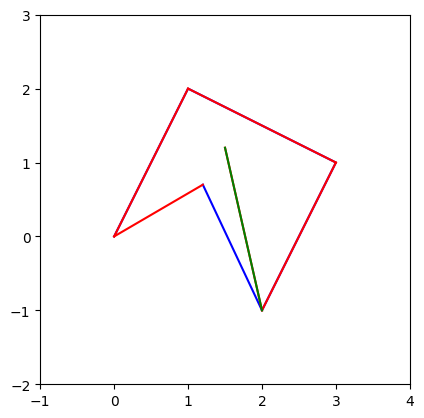

In [ ]:

def generate_polygon_shells(vertices, quad_edges, chunk_size=100):
    shells = []
    visited_edges = set()
    processed_edges = set()

    num_edges = len(quad_edges)

    start_idx = 0
    end_idx = min(chunk_size, num_edges)

    chunk_edges = quad_edges[start_idx:end_idx]

    for edge in chunk_edges:
        if edge in visited_edges:
            continue

        shell = []
        current_edge = edge
        visited_edges.add(current_edge)

        while True:
            shell.append(current_edge.org)
            current_edge = current_edge.onext

            if current_edge in visited_edges:
                break

            visited_edges.add(current_edge)
            processed_edges.add(current_edge)

        shells.append(shell)

    visited_edges -= processed_edges
    processed_edges.clear()

    return shells

# Call the generate_polygon_shells function
shells = generate_polygon_shells(vertices, quad_edges,10)

def display_quad_edge_with_shells(vertices, quad_edges, shells):
    # Create a new figure and axis
    fig, ax = plt.subplots()

    # Convert the vertices to numpy array for easier manipulation
    vertices = np.array(vertices)

    # Plot the polygon
    ax.plot(vertices[:, 0], vertices[:, 1], 'b-')

    # Plot the quad edges
    for edge in quad_edges:
        start = edge.org
        end = edge.dest

        ax.plot([start[0], end[0]], [start[1], end[1]], 'r-')
    
    # Plot the polygon shells
    for shell in shells:
       shell = np.array(shell)
       ax.plot(shell[:, 0], shell[:, 1], 'g-')

    # Set plot attributes
    ax.set_aspect('equal')
    ax.set_xlim(vertices[:, 0].min() - 1, vertices[:, 0].max() + 1)
    ax.set_ylim(vertices[:, 1].min() - 1, vertices[:, 1].max() + 1)

    # Display the plot
    plt.show()
# Call the display_quad_edge_with_shells function
display_quad_edge_with_shells(vertices, quad_edges, shells)